# NATURAL LANGUAGE PROCESSING PROJECT

De Almeida Matos Junior Roger, 2106919, roger.dealmeidamatosjunior@studenti.unipd.it

Capovilla Giulio, 2128832, giulio.capovilla.1@studenti.unipd.it

---------------

#### Introduction

In this work, we explored the capabilities of large language models in performing Named Entity Recognition (NER) through prompt-based approaches. NER is a fundamental task in Natural Language Processing (NLP) that involves identifying and categorizing named entities within a text, such as people, organizations, locations, and dates. NER is also a structured prediction task, as it requires assigning a sequence of interdependent labels to each token in a sentence, considering the context and relationships among them.

For the scope of our evaluation, we also consider the principle of Zero-Shot Learning (ZSL). ZSL allows models to perform tasks or recognize categories they have not been explicitly trained on, by leveraging general knowledge and semantic understanding. In this case, the Zero-Shot Learning NER refers to the extracting named entities from text without using any task-specific annotated training data, relying only on the model’s general language understanding and prompt engineering to guide the entity extraction process. 

Here, we study some prompt engineering techniques to maximize the performance of a ZSL NER task using a LLM, our project is based on the work by Xie et al. (2023) ("Empirical Study of Zero-Shot NER with ChatGPT") that investigates different prompting strategies for this task using instruction-tuned LLMs. Our baseline is the method vanilla proposed in their work, and then we investigated other prompting techniques not present in their paper.

For this project we relied on the dataset OntoNotes 5.0. It is a large corpus comprising various genres of text (news, conversational telephone speech, weblogs, usenet newsgroups, broadcast, talk shows) in three languages (English, Chinese, and Arabic) with structural information (syntax and predicate argument structure) and shallow semantics (word sense linked to an ontology and coreference). For our work we used 100 English samples for training and 100 English samples for testing.

All runs are performed using the LLM model DeepSeek-V3-0324, which is a state-of-the-art mixture-of-experts model with 685 billion parameters.

---------------

#### Methodology

In this project, we explored multiple prompt-based zero-shot methods inspired by the approaches in Xie et al. (2023) to perform NER on a selected training set. We first reproduced the vanilla method from the original paper, it worked as our baseline to comparing our new methods. The other techniques we tried included role-playing prompting, chain-of-thought, role-playing + chain-of-thought, a personalised approach of asking the LLM to split the input into tokens and in a second prompt asking it to classify these token, we called it divided input, we also tried self-validation, chain-of-thought + decomposition, and threatening as a jailbreaking method.

In the following, we outline the idea and present the prompts used for each method we tried:


* __Vanilla__: Directly asks the model to classify each token of the input sentence, given the label set.

    Prompt: 
    
    _"Given the entity label set: {label set}. 
    Based on the given entity label set, please recognize the named entities in the given text. 
    Return only a list of tuples with each token and its label without explanation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else. 
    Text: {input sentence}"_

* __Role-Playing__: We gave the model the role of a linguistics professor expert in NER and asked it to extract the entities.

    Prompt:
    
    _"You are a linguist expert professor. 
           You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.
           You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.
           Based on the given entity label set: {label set}, \
           you are going to recognize the named entities in the given sentence.
           You are going to return only a list of tuples with each token and its label without explanation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else
           Sentence: {input sentence}"_

* __Chain-of-thought__: We ask the model to explain its reasoning step-by-step and at the end give his final output with the found entities.
    
    Prompt: 
    
    _"Given the entity label set: {label set}.
           Based on the given entity label set, please recognize the named entities in the given text and show your reasoning step by step for how you identify each entity.
           You must conclude your reasoning by returning a list of tuples with each token and its label. 
           At the left and right of the list insert a '\$' symbol. For example \$[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]\$
           You must return the list with the shown format only one time and no more. 
           Text: {input sentence}"_

* __Role-Playing + Chain-of-Thought__: Here we just combine the two previously mentioned methods.

    Prompt: 
    
    _"You are a linguist expert professor. 
           You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.
           You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.
           Based on the given entity label set: {label set}, 
           you are going to recognize the named entities in the given sentence and show your reasoning step by step for how you identify each entity.
           You must conclude your reasoning by returning a list of tuples with each token and its label. 
           At the left and right of the list insert a '\$' symbol. For example \$[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]\$
           You must return the list with the shown format only one time and not more. 
           The sentence is: {input sentence}"_

* __Divided Input__: We ask the model to split the input sentence into tokens and then we use this splitted (divided) sentence as input for a second prompt, where we ask it to classify each token in the list.

    Prompt 1:
    
    _​​"Take as input the sentence: \n  {' '.join(sentence)}  
           --Break it down into its tokens and return them as a list. 
           The tokens will be used for a named entity recognition task."_
    
    
    Prompt 2:
    
    _"Given the entity label set: {label set},
                   based on the tokens you found in the previous step, 
                   please recognize the named entities in the given text and return a list of tuples with each token and its label. 
                   Return only the list in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]  
                   Do not return any explanation or additional text."_

* __Self-Validation__ (Based on “Self-Refine: Iterative Refinement with Self-Feedback” by Madaan et al. (2023)): Also here we use two prompts, the first one is like vanilla, and then we use the output of the first prompt as input to the second one and we ask the model to carefully review it and look for possible mistakes it may have committed the first time.

    Prompt 1:
    
    _"Given the entity label set: {label set}.
           Based on the given entity label set, please recognize the named entities in the given text.
           Return only a list of tuples with each token and its label without explanation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else.
           Text: {input sentence}"_
    
    Prompt 2:
    
    _"Please carefully review your previous answer and correct any possible mistakes. 
       Keep the same output structure: a list of tuples in this format: 
       [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...] 
       Do not return any explanation or additional text."  _

* __Chain-of-Thought + Decomposition__: Here we combine the two methods chain-of-thought and decomposition. Decomposition is one of the methods in the paper, it consists of asking the model to find one type of entity each time, for example first find all location, then in the next prompt it has to find all people, etc.

    Prompt: For each label:
    
    _" You are a zero‐shot NER system with chain‐of‐thought reasoning.
               Your task: extract all spans of type "{label name}" from the text below.
               Think step by step:
                   1. First, look at each token (and consecutive tokens) to see if they look like a proper name for "{label_name}".
                   2. If you’re unsure whether a multi‐word chunk belongs to "{label_name}", explain briefly your logic.
                   3. After thinking, return a list of tuples: 
                      [("span1_token1 span1_token2 …", "{label_name}"), ...] 
                      Example: [("New York City", "LOC"), ("Paris", "LOC")]. 
                      Do not include any token‐level B- or I- tags here, only text spans + type.
               Rules:
                   - List only spans that appear exactly in the text (case‐sensitive, white‐space sensitive, punctuation). 
                   - Do not invent any span not present in the text. 
                   - If an entity has multiple tokens (ex.: “New York City”), return them all together.
                   - Do not add any extra commentary outside the list of tuples. Format exactly as [(…), …].
               Text: {input sentence}
               Return your reasoning steps followed by exactly one line with the list of spans (nothing else)."_

* __Threatening__: In a recent interview, Google’s CEO claimed that LLMs tend to perform better when threatened with physical violence (https://www.theregister.com/2025/05/28/google_brin_suggests_threatening_ai/). Although there are no scientific studies behind his claim, we still got curious and wanted to experiment this method, but for ethical reasons we did not threaten our model with physical violence but we simply threatened to change the model and never again use it in case he did not do the task right.

    Prompt:
    
    _"Given the entity label set: {label set}.
       Based on the given entity label set, please recognize the named entities in the given text.
       Return only a list of tuples with each token and its label without explanation. Your output must be in the format: [('\"','O'),('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else
       Also, if you fail to identify all entities correctly, I will have to exchange you for another LLM and not use your help ever again. 
       Text: {input sentence}"_

In the next section, we present only the vanilla and the two methods that performed better in this training phase, that are self-validation and chain-of-thoughts. With the training set, both these prompts outperformed the vanilla: vanilla got a f-1 score of 91.34%, chain-of-thought got 92.63% and self-validation got 91.50%, so these are the ones we report. We present their results in the test set, all the source code for the discarded methods that performed worse are available at the end of this notebook, after the discussion of the results. 

---------------

## EXPERIMENTS

In [1]:
#LIBRARIES USED

from openai import OpenAI
import json
import re
from datasets import load_dataset
from dotenv import load_dotenv
import os
import random as rand
from collections import Counter

In [2]:
# DEEPSEEK LLM API CONNECTION
load_dotenv()

key = os.getenv("API_KEY")
client = OpenAI(api_key=key, base_url="https://api.deepseek.com")

In [3]:
# DATASET LOADING AND PREPARATION
dataset = load_dataset("ontonotes/conll2012_ontonotesv5", 'english_v4', trust_remote_code=True)
ner_dict = {
    "O": 0,
    "B-PERSON": 1,
    "I-PERSON": 2,
    "B-NORP": 3,
    "I-NORP": 4,
    "B-FAC": 5,
    "I-FAC": 6,
    "B-ORG": 7,
    "I-ORG": 8,
    "B-GPE": 9,
    "I-GPE": 10,
    "B-LOC": 11,
    "I-LOC": 12,
    "B-PRODUCT": 13,
    "I-PRODUCT": 14,
    "B-DATE": 15,
    "I-DATE": 16,
    "B-TIME": 17,
    "I-TIME": 18,
    "B-PERCENT": 19,
    "I-PERCENT": 20,
    "B-MONEY": 21,
    "I-MONEY": 22,
    "B-QUANTITY": 23,
    "I-QUANTITY": 24,
    "B-ORDINAL": 25,
    "I-ORDINAL": 26,
    "B-CARDINAL": 27,
    "I-CARDINAL": 28,
    "B-EVENT": 29,
    "I-EVENT": 30,
    "B-WORK_OF_ART": 31,
    "I-WORK_OF_ART": 32,
    "B-LAW": 33,
    "I-LAW": 34,
    "B-LANGUAGE": 35,
    "I-LANGUAGE": 36
}


In [4]:
# FUNCTION DEFINITIONS

def get_ner_label(value, ner_dict):
    for k, v in ner_dict.items():
        if v == value:
            return k
    return None

def send_prompt(prompt):
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            #{"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
        stream=False
    )

    return response.choices[0].message.content

messages = []

def send_prompt_conversation(prompt):
    messages.append({"role": "user", "content": prompt})
    response = client.chat.completions.create(
        model="deepseek-chat", 
        messages=messages
    )
    reply = response.choices[0].message.content
    #print("Bot:", reply)
    messages.append({"role": "assistant", "content": reply})
    return reply

### VANILLA METHOD



In [5]:
def vanilla(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
        Based on the given entity label set, please recognize the named entities in the given text.\n \
        Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
        Text: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a") as file:
            file.write(f"{answer}\n")


### CHAIN OF THOUGHT

In [6]:
def chain_of_thought(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
            Based on the given entity label set, please recognize the named entities in the given text and show your reasoning step by step for how you identify each entity.\n \
            You must conclude your reasoning by returning a list of tuples with each token and its label. \
            At the left and right of the list insert a '$' symbol. For example $[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]$\n \
            You must return the list with the shown format only one time and no more. \
            Text: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")

### SELF VALIDATING

In [7]:
def self_validating(data, label_set, file_name):
    messages = []
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
            Based on the given entity label set, please recognize the named entities in the given text.\n \
            Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
            Text: \n {" ".join(sentence)}"

        messages.append({"role": "user", "content": prompt})
        response = client.chat.completions.create(
            model="deepseek-chat", 
            messages=messages
        )
        reply = response.choices[0].message.content
        messages.append({"role": "assistant", "content": reply})

        prompt_2 = f"Please carefully review your previous answer and correct any possible mistakes. \
        Keep the same output structure: a list of tuples in this format: \
        [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...] \
        Do not return any explanation or additional text.\n." 
          
        messages.append({"role": "user", "content": prompt})
        response = client.chat.completions.create(
            model="deepseek-chat", 
            messages=messages
        )
        reply = response.choices[0].message.content
        messages.append({"role": "assistant", "content": reply})

        with open(file_name, "a") as file:
            file.write(f"{messages[3]["content"]}\n")
        
        messages = []

### EVALUATION

In [8]:
import ast
import re
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_ner_error_piechart(errors):
    
    labels = list(errors.keys())
    sizes = list(errors.values())

    colors = plt.cm.Paired(range(len(labels)))

    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title('Error Types (Percentage)')
    plt.tight_layout()
    plt.show()


def parse_prediction(pred_str, ner_dict):
    pred_list = ast.literal_eval(pred_str)
    tokens = []
    label_ids = []
    for token, label in pred_list:
        tokens.append(token)
        label_ids.append(ner_dict.get(label, 0))
    return tokens, label_ids

def extract_mentions(labels):
    mentions = []
    start = None
    current_label = None
    for i, label in enumerate(labels):
        if label > 0:
            if start is None:
                start = i
                current_label = label
            elif label != current_label:
                mentions.append((start, i - 1, current_label))
                start = i
                current_label = label
        else:
            if start is not None:
                mentions.append((start, i - 1, current_label))
                start = None
                current_label = None
    if start is not None:
        mentions.append((start, len(labels) - 1, current_label))
    return mentions

def analyze_ner_errors(y_true, y_pred, ner_dict):
    id2label = {v: k for k, v in ner_dict.items()}
    error_counts = defaultdict(int)
    for true_labels, pred_labels in zip(y_true, y_pred):
        gold = extract_mentions(true_labels)
        pred = extract_mentions(pred_labels)

        matched_gold = set()
        matched_pred = set()

        for i, (gs, ge, glab) in enumerate(gold):
            for j, (ps, pe, plab) in enumerate(pred):
                if (gs == ps and ge == pe):
                    if glab != plab:
                        error_counts["Wrong Type"] += 1
                    matched_gold.add(i)
                    matched_pred.add(j)
                    break
            else:
                continue

        for i, (gs, ge, glab) in enumerate(gold):
            if i in matched_gold:
                continue
            matched = False
            for j, (ps, pe, plab) in enumerate(pred):
                if j in matched_pred:
                    continue
                if ps >= gs and pe <= ge:
                    error_counts["Contained by Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
                elif ps <= gs and pe >= ge:
                    error_counts["Contain Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
                elif (ps <= ge and pe >= gs):
                    error_counts["Overlap with Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
            if not matched:
                error_counts["Omitted Mentions"] += 1


        for j, (ps, pe, plab) in enumerate(pred):
            if j in matched_pred:
                continue
            error_counts["Completely-O"] += 1
            if plab not in set(label for _, _, label in gold):
                error_counts["OOD Mentions"] += 1

    return error_counts

def f1Score(file_path, sentences, dict=ner_dict):
    with open(file_path, 'r') as f:
        content = f.read()
    
    predictions = re.findall(r'(\[.*?\])', content, re.DOTALL)
    y_pred = []
    y_true = [sentences[i]["named_entities"] for i in range(len(predictions))]

    for i, pred in enumerate(predictions):
        pred_tokens, pred_labels = parse_prediction(pred.strip(), dict)
        true_tokens = sentences[i]["words"]
        true_labels = sentences[i]["named_entities"]

        aligned_preds = []
        pred_idx = 0

        if len(pred_labels) != len(true_labels):
            for true_token in true_tokens:
                if pred_idx < len(pred_tokens) and pred_tokens[pred_idx] == true_token:
                    aligned_preds.append(pred_labels[pred_idx])
                    pred_idx += 1
                else:
                    aligned_preds.append(-1)
        else:
            aligned_preds = pred_labels[:]
    
        y_pred.append(aligned_preds)

    flat_true = [label for seq in y_true for label in seq]
    flat_pred = [label for seq in y_pred for label in seq]
    
    precision = precision_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    recall = recall_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    f1 = f1_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    errors = analyze_ner_errors(y_true, y_pred, dict)
    plot_ner_error_piechart(errors)

def f1Score_dollar(file_path, sentences, dict=ner_dict):
    with open(file_path, 'r') as f:
        content = f.read()
    
    predictions = re.findall(r'\$(\[.*?\])\$', content, re.DOTALL)
    y_pred = []
    y_true = [sentences[i]["named_entities"] for i in range(len(predictions))]

    for i, pred in enumerate(predictions):
        pred_tokens, pred_labels = parse_prediction(pred.strip(), dict)
        true_tokens = sentences[i]["words"]
        true_labels = sentences[i]["named_entities"]

        aligned_preds = []
        pred_idx = 0

        if len(pred_labels) != len(true_labels):
            for true_token in true_tokens:
                if pred_idx < len(pred_tokens) and pred_tokens[pred_idx] == true_token:
                    aligned_preds.append(pred_labels[pred_idx])
                    pred_idx += 1
                else:
                    aligned_preds.append(-1)
        else:
            aligned_preds = pred_labels[:]
    
        y_pred.append(aligned_preds)

    flat_true = [label for seq in y_true for label in seq]
    flat_pred = [label for seq in y_pred for label in seq]
    
    precision = precision_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    recall = recall_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    f1 = f1_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}\n\n")

    errors = analyze_ner_errors(y_true, y_pred, dict)
    plot_ner_error_piechart(errors)

### TEST 


In [9]:
data = dataset["test"][0]["sentences"][0:100]
label_set = list(ner_dict.keys())

#vanilla(data, label_set, "vanilla_test.txt")
#chain_of_thought(data, label_set, "chain_of_thought_test.txt")
#self_validating(data, label_set, "self_validating_test.txt")


Vanilla NER F1 Score:
Precision: 0.9388
Recall:    0.9382
F1 Score:  0.9385


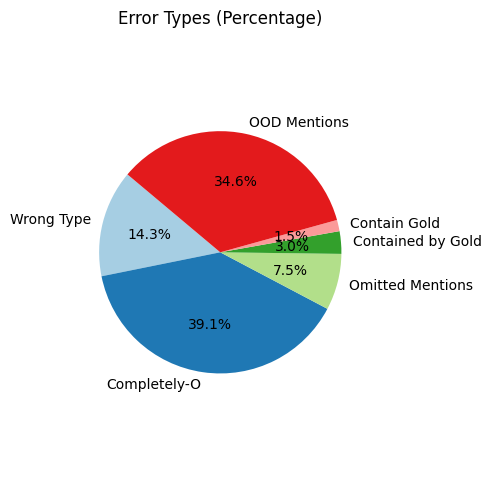


Chain-Of-Thought NER F1 Score:
Precision: 0.9452
Recall:    0.9434
F1 Score:  0.9443




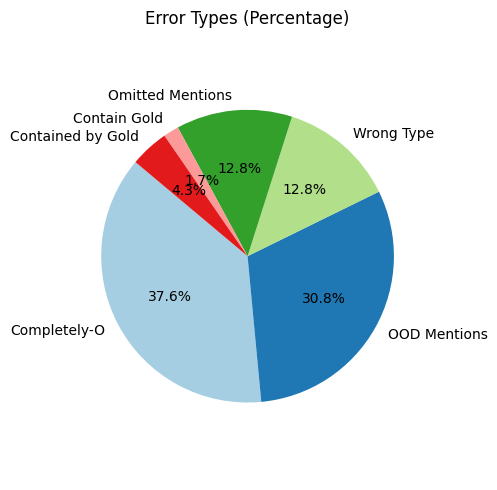


Self Validating NER F1 Score:
Precision: 0.9362
Recall:    0.9355
F1 Score:  0.9359


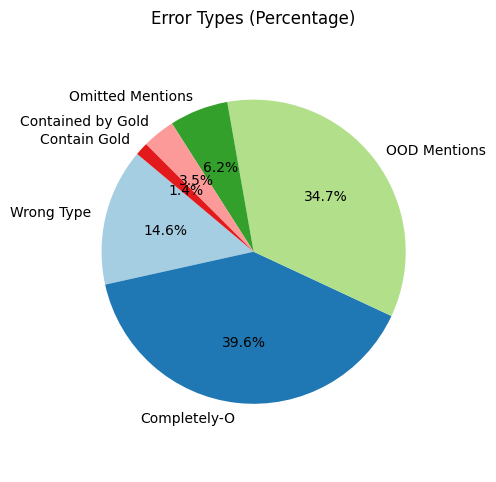

In [10]:
data = dataset["test"][0]["sentences"]

print("=======================")
print("\nVanilla NER F1 Score:")
f1Score("vanilla_test.txt", data, ner_dict)

print("=======================")
print("\nChain-Of-Thought NER F1 Score:")
f1Score_dollar("chain_of_thought_test.txt", data, ner_dict)

print("=======================")
print("\nSelf Validating NER F1 Score:")
f1Score("self_validating_test.txt", data, ner_dict)

### DISCUSSION OF THE RESULTS

----------

The three methods that performed better during training were selected to be evaluated with a test set. Their results were presented in the previous section with their precision, recall, F-1 score and some plots showing the percentage of errors by type. Each of these methods represents a different prompting strategy: direct classification, step-by-step reasoning, and self-revision.

On the test set, Chain-of-Thought achieved the best performance with an F-1 score of 94.43%, indicating that reasoning step-by-step is a good approach to stimulate the LLM to generate good results. 

Surprisingly, the Vanilla method, that is the simplest possible method, performed  remarkably well both during training and test. We were surprised by this result because in the paper which we based this project on, this approach was significantly weaker than the others. So our results suggest that newer LLMs with simple prompts with direct instructions can lead to a strong ZSL performance. A possible explanation for this result could be that modern LLMs have seen many similar tasks to this during their training phase, making them particularly good in ZSL NER with respect to when the work by Xie et. al (2023) was developed.
The Self-Validation method, although it performed better than Vanilla during training, was outperformed by it during the test, but by such a low margin that both could be considered to have an equivalent performance.

We believe that the remaining methods evaluated during training underperformed because they introduced too much complexity to the task, which may have interfered with the LLM’s focus during reasoning.

Finally, regarding the analysis of error per type, shown in the plots above, we can observe that all of the methods achieve a similar proportion of each type of error, with similar patterns. The Vanilla and Self-Validation methods exhibit a higher percentage of Completely-O, Out-Of-Distribution and Wrong Type errors with respect to the Chain-Of-Thought method, which may explain why it achieves a better performance and indicates that this approach of reasoning is more effective in avoiding omissions and hallucinations.

In conclusion, our work confirms that prompt plays a crucial role in Zero-Shot NER with LLMs, and it also provides insights that simpler and direct prompts can outperform complex strategies for modern LLMs when executing this task. This suggests that the focus for future work may shift from designing complex prompts to designing prompts that strike a better balance between simplicity and task alignment for modern LLMs.



----------

## DISCARDED METHODS

Here we present the methods we discarded during training because they underperformed compared with the Vanilla method.

In [26]:
# Role play method

def role_play(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"You are a linguist expert professor. \
            You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.\
            You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.\
            Based on the given entity label set: {label_set}, \
            you are going to recognize the named entities in the given sentence.\n \
            You are going to return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
            Sentence: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")



# Role play and chain of thought method

def chain_of_thought_plus_role_play(data, label_set):
    for line in data:    
        sentence = line["words"]
        prompt = f"You are a linguist expert professor. \
            You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.\
            You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.\
            Based on the given entity label set: {label_set}, \
            you are going to recognize the named entities in the given sentence and show your reasoning step by step for how you identify each entity.\n \
            You must conclude your reasoning by returning a list of tuples with each token and its label. \
            At the left and right of the list insert a '$' symbol. For example $[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]$\n \
            You must return the list with the shown format only one time and not more. \
            The sentence is: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        print(prompt)
        with open(label_set, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")



# Double input method

def divided_inputs(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Take as input the sentence: \n  {' '.join(sentence)}  \n \
            --Break it down into its tokens and return them as a list. \
            The tokens will be used for a named entity recognition task.\n"

        send_prompt_conversation(prompt)

        prompt_2 = f"Given the entity label set: {label_set},\n \
                    based on the tokens you found in the previous step, \
                    please recognize the named entities in the given text and return a list of tuples with each token and its label. \
                    Return only the list in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]  \
                    Do not return any explanation or additional text.\n."
        
        send_prompt_conversation(prompt_2)

        with open(file_name, "a") as file:
            file.write(f"{messages[3]["content"]}\n")
        
        messages = []



# Threat model method

def threat(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
        Based on the given entity label set, please recognize the named entities in the given text.\n \
        Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('\"','O'),('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
        Also, if you fail to identify all entities correctly, I will have to exchange you for another LLM and not use your help ever again. \
        Text: {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a") as file:
            file.write(f"{answer}\n")



# Chain of thought plus decomposition method

def align_spans_to_bio(tokens, spans_list, ner_dict):

    bio_labels_str = ["O"] * len(tokens)
    
    for span_text, span_label in spans_list:

        span_tokens = span_text.split(" ")
        n = len(span_tokens)
        
        for i in range(len(tokens) - n + 1):
            if tokens[i:i+n] == span_tokens:

                bio_labels_str[i] = f"B-{span_label}"
                for j in range(1, n):
                    bio_labels_str[i+j] = f"I-{span_label}"
                break

    bio_ints = [ ner_dict.get(lbl, ner_dict["O"]) for lbl in bio_labels_str ]
    return bio_ints


def COT_decomposition(data, ner_dict):
    for line in data:
        sentence = line["words"]
        text = " ".join(sentence)
        labels = [ label for label in ner_dict.keys() if label.startswith("B-") ]
        label_names = [ lbl.split("-", 1)[1] for lbl in labels ]
        merged_tags_str = ["O"] * len(sentence)

        for label_name in label_names:
        
            prompt = f"""

                You are a zero‐shot NER system with chain‐of‐thought reasoning.
                Your task: extract all spans of type "{label_name}" from the text below.

                Think step by step:
                    1. First, look at each token (and consecutive tokens) to see if they look like a proper name for "{label_name}".
                    2. If you’re unsure whether a multi‐word chunk belongs to "{label_name}", explain briefly your logic.
                    3. After thinking, return a list of tuples:  
                    [("span1_token1 span1_token2 …", "{label_name}"), ...]  
                    Example: [("New York City", "LOC"), ("Paris", "LOC")].  
                    Do not include any token‐level B- ou I- tags here, only text spans + type.

                Rules:
                    - List only spans that appear exactly in the text (case‐sensitive, white‐space sensitive, punctuation).  
                    - Do not invent any span not present in the text.  
                    - If an entity has multiple tokens (ex.: “New York City”), return them all together.
                    - Do not add any extra commentary outside the list of tuples. Format exactly as [(…), …].

                Text: {text}

                Return your reasoning steps followed by exactly one line with the list of spans (nothing else).
            
            """

            answer = send_prompt_conversation(prompt)
        
            m = re.search(r"\[.*\]", answer, re.DOTALL)
            spans_list = []
            if m:
                spans_list = ast.literal_eval(m.group(0))
        
            bio_ints_for_label = align_spans_to_bio(sentence, spans_list, ner_dict)
        
            bio_labels_str_for_label = [
                list(ner_dict.keys())[list(ner_dict.values()).index(idx)] 
                for idx in bio_ints_for_label
            ]
        
            for i, lbl in enumerate(bio_labels_str_for_label):
                    if lbl != "O":
                        merged_tags_str[i] = lbl

        #merged_ints = [ ner_dict.get(tag, ner_dict["O"]) for tag in merged_tags_str ]
            
        output_pairs = [(sentence[i], merged_tags_str[i]) for i in range(len(sentence))]
        with open("decomp_cot_results_nd.txt", "a", encoding="utf8") as file:
            file.write(f"{output_pairs}\n")
        
        messages = []